# Beyond a one-dimensional sequence
The Sequencer is essentially a dimensionality reduction algorithm, since it provides a one-dimensional embedding of the input dataset. This is one of the main differences between the Sequencer and other dimensionality reduction algorithms, such as tSNE and UMAP, which can embed the input dataset into higher dimensions as well (2D or 3D). In this notebook, I show how we can go beyond a one-dimensional sequence using a method somewhat similar to PCA: once we detect the main trend in the data, we can 'strip' it from the data, and apply the Sequencer to the residual dataset to look for the second strongest trend. <br>
The notebook is divided into the following parts: <br>
1. **Simulating a dataset with two sequences:** in this part of the notebook we will simulate a dataset with two unrelated sequences. The dataset will be built in a way that one sequence is more significant than the other. <br>
2. **Finding the strongest trend:** we will apply the Sequencer to the simulated dataset to find the strongest trend in the data. <br>
3. **Stripping the main trend from the data:** I will show how we can strip the main trend from the data, by constructing a smoothed version of the ordered dataset, and subtracting (or dividing) it from the original data. This results in a residual dataset that is stripped out of the main trend. <br>
4. **Finding the second strongest trend:** we will then apply the Sequencer to the residual data with the goal of detecting the second strongest trend. <br>

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib
#!pip install TheSequencer

In [3]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from scipy.stats import chi2

import sequencer

## Simulate a dataset with two unrelated sequences
In this notebook we will simulate a dataset with two unrelated sequences. The first, strongest, sequence will be driven by large-scale variations of the intensity. 

In [10]:
x = numpy.linspace(0, 10, 200)

df_list = numpy.linspace(0.1, 9, 200)
y_list = []
for i, df_val in enumerate(df_list):
    y = chi2.pdf(x, df_val)
    y_list.append(y)

y_list = numpy.array(y_list)
print(y_list.shape)

(200, 200)


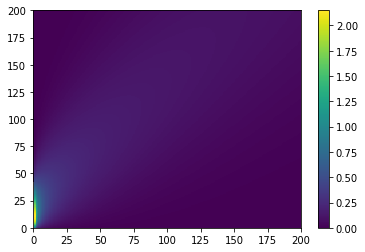

In [11]:
plt.pcolormesh(y_list)
plt.colorbar()